# Problem Statement:

**In this homework assignment, we are going to use Cluster Analysis and Decision Tree induction algorithm
on a weather forecast problem. It is a binary classification problem to predict whether or not a location will
get rain the next day.<br>
Information about the dataset (Weather Forecast Training.csv):<br>
• Location: The location name of the weather station<br>
• MinTemp: The minimum temperature in degrees celsius<br>
• MaxTemp: The maximum temperature in degrees celsius<br>
• Rainfall: The amount of rainfall recorded for the day in mm<br>
• Evaporation: The so-called Class A pan evaporation (mm) in the 24 hours to 9am<br>
• Sunshine: The number of hours of bright sunshine in the day.<br>
• WindGustDir: The direction of the strongest wind gust in the 24 hours to midnight<br>
• WindGustSpeed: The speed (km/h) of the strongest wind gust in the 24 hours to midnight<br>
• WindDir: Direction of the wind<br>
• WindSpeed: Wind speed (km/hr) averaged over 10 minutes<br>
• Humidity: Humidity (percent)<br>
• Pressure: Atmospheric pressure (hpa) reduced to mean sea level<br>
• Cloud: Fraction of sky obscured by cloud This is measured in “oktas”, which are a unit of eigths. It
records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky
whilst an 8 indicates that it is completely overcast.<br>
• Temp: Temperature (degrees C)<br>
• RainTodayBoolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0<br>
• RainTomorrow: The target variable. Did it rain tomorrow?<br>**

In [0]:
#importing all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,classification_report,recall_score,roc_curve,roc_auc_score
seed = np.random.seed(22)
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram

In [0]:
#Reads both the data as we will be cleaning both the data simultaneously
data=pd.read_csv("Weather Forecast Training.csv")
test_data=pd.read_csv("Weather Forecast Testing.csv")

In [0]:
#Duplicate rows will be dropped as it will only create noise in our data
data.drop_duplicates(keep='first',inplace=True)

# Data Preparation

Below we can see that there are lot of missing values in our data. Columns like Evaporation, Sunshine and Cloud have close to 50% of the values missing. So, we drop this columns as we don't have enough values to perform imputation for this columns.

In [4]:
data.isnull().sum()

Location             0
MinTemp            268
MaxTemp            116
Rainfall           745
Evaporation      22534
Sunshine         24856
WindGustDir       3579
WindGustSpeed     3552
WindDir           1494
WindSpeed         1005
Humidity          1410
Pressure          5047
Cloud            20111
Temp              1044
RainToday          745
RainTomorrow         0
dtype: int64

In [0]:
data.drop(["Evaporation","Sunshine","Cloud"],inplace=True,axis=1)
test_data.drop(["Evaporation","Sunshine","Cloud"],inplace=True,axis=1)

In [6]:
#Below we check for the number of unique values in each column
data.nunique()

Location          49
MinTemp          372
MaxTemp          484
Rainfall         599
WindGustDir       16
WindGustSpeed     66
WindDir           16
WindSpeed         40
Humidity         100
Pressure         523
Temp             479
RainToday          2
RainTomorrow       2
dtype: int64

### Outliers

**After plotting the boxplots of various variables, the points that were considered outliers which had a very high value compared to other data points and were also not following the pattern of the data. One such point that was found was in the Rainfall column.** 

Here, we can see that the data point with rainfall was greater than 350 which is comparatively very high. So, we remove this point from our data


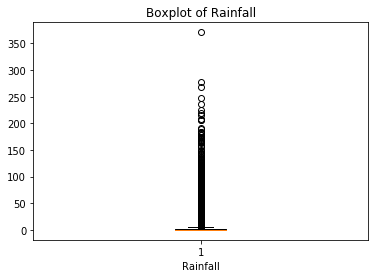

In [7]:
print("Here, we can see that the data point with rainfall was greater than 350 which is comparatively very high. So, we remove"
     " this point from our data")
plt.boxplot(data[data.Rainfall.notnull()].Rainfall);
plt.xlabel("Rainfall")
plt.title("Boxplot of Rainfall");

In [0]:
#Removes the row which has unusally high rainfall.
data.drop(data[data.Rainfall>300].Rainfall.index,inplace=True)

In [0]:
#Next we convert the Rainfall column into 0 and 1 which is required when we run the models on our data. As the input for the 
#models should be numerical and not string. Also, it will help us to plot correlation matrix.
data.RainToday.replace({"No":0,"Yes":1},inplace=True)
test_data.RainToday.replace({"No":0,"Yes":1},inplace=True)

In [0]:
#We do the above data transformation for RainTomorrow as well.
data.RainTomorrow.replace({"No":0,"Yes":1},inplace=True)

**Correlation Matrix**

**Below we plot the correlation matrix in order to understand if there is any strong relationship between the columns which can 
help us to impute data.**

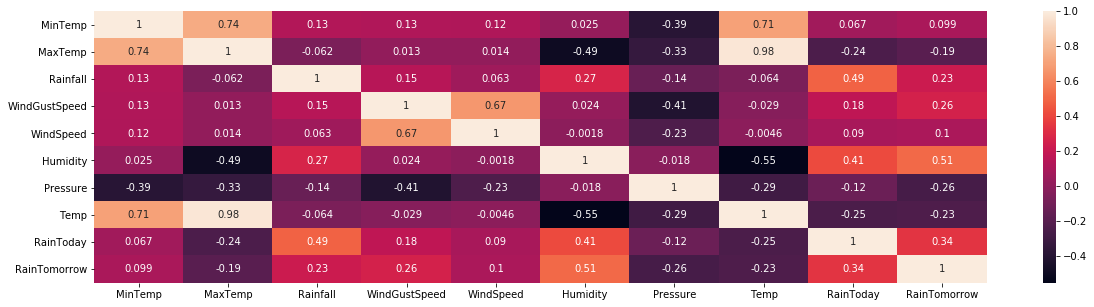

In [11]:
plt.figure(figsize=(20,5))
sns.heatmap(data.corr(),annot=True);

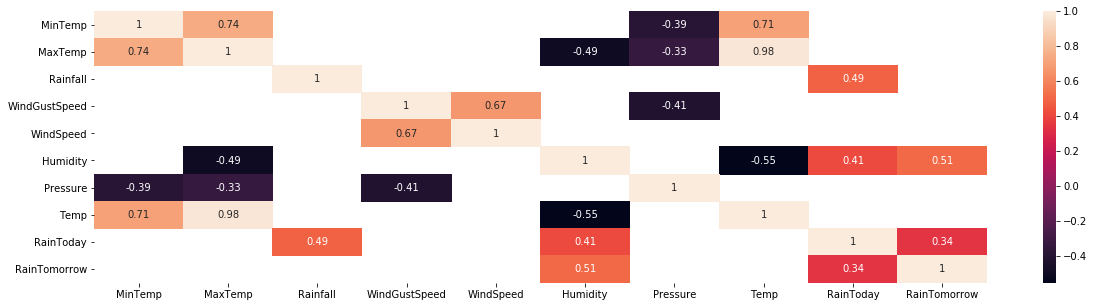

In [12]:
#Below we plot a correlation matrix which has absolute correlation value greater than 0.3.
plt.figure(figsize=(20,5))
sns.heatmap(data.corr()[abs(data.corr())>.3],annot=True);

### Data Imputation

**As our data contains lot of missing value, it is very important to impute it carefully. Below is the code with explanation of how the missing values were imputed.**

**From the correlation matrix, we can see that there is a high correlation between the Temp and Max Temp column. So, with the help of the Temp column we fill the missing values for MaxTemp and then drop the Temp column as it has high correlation with the MaxTemp.** 

In [0]:
data['MaxTemp'] = data.apply(lambda row: row['Temp'] if np.isnan(row['MaxTemp']) else row['MaxTemp'],axis=1)

data.drop("Temp",inplace=True,axis=1)

In [0]:
#Performing the same for test_data
test_data['MaxTemp'] = test_data.apply(lambda row: row['Temp'] if np.isnan(row['MaxTemp']) else row['MaxTemp'],axis=1)
test_data.drop("Temp",inplace=True,axis=1)

**From the below plots we can see that the difference between the Min Temp and Max Temp is a normal distribution with a slight right skew. So, we use the median of average difference for a particular location for imputation of missing values of MinTemp and MaxTemp using the corresponding MinTemp or MaxTemp.**

Histogram plot of difference in MinTemp and MaxTemp for different locations:



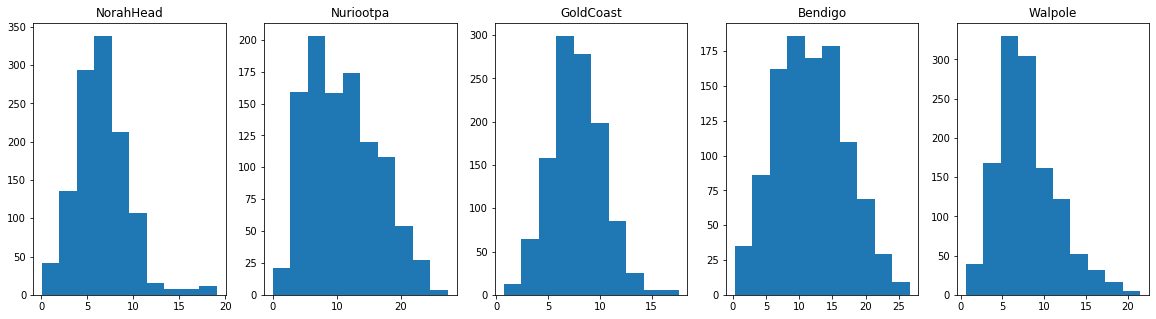

In [15]:
fig,ax=plt.subplots(1,5,figsize=(20,5))
print("Histogram plot of difference in MinTemp and MaxTemp for different locations:\n");
for j,i in enumerate(data.Location.unique()):
    if j<5:
        ax[j].hist(data[data.MinTemp.notnull() & (data.Location==i) & (data.MaxTemp.notnull())].MaxTemp-
                   data[data.MinTemp.notnull() & (data.Location==i) & (data.MaxTemp.notnull())].MinTemp)
        ax[j].set_title(i)

In [0]:
#Dictionary which contains the location and the corresponding median of difference between Min Temp and MaxTemp.
avg_difference_temp={i:np.median(data[(data.MaxTemp.notnull()) & (data.MinTemp.notnull()) & (data.Location==i)].MaxTemp-data[(data.MaxTemp.notnull()) & (data.MinTemp.notnull()) & (data.Location==i)].MinTemp) for i in data.Location.unique()} 

for i in data[data["MinTemp"].isnull()].index:
    data.loc[i,"MinTemp"]=data.loc[i,"MaxTemp"]-avg_difference_temp[data.loc[i,"Location"]]

for i in data[data["MaxTemp"].isnull()].index:
    data.loc[i,"MaxTemp"]=data.loc[i,"MinTemp"]+avg_difference_temp[data.loc[i,"Location"]]

In [0]:
#Perfroming the same for test_data
for i in test_data[test_data["MinTemp"].isnull()].index:
    test_data.loc[i,"MinTemp"]=test_data.loc[i,"MaxTemp"]-avg_difference_temp[test_data.loc[i,"Location"]]

for i in test_data[test_data["MaxTemp"].isnull()].index:
    test_data.loc[i,"MaxTemp"]=test_data.loc[i,"MinTemp"]+avg_difference_temp[test_data.loc[i,"Location"]]

**For rows which have WindGustDir and WindDir missing, the corresponding WindGustDir or WindDir value were substituted as there were no other way of making the imputation that made more sense.**

In [0]:
data['WindGustDir'] = data.apply(lambda row: row['WindDir'] if pd.isnull(row['WindGustDir']) else row['WindGustDir'],axis=1)
data['WindDir'] = data.apply(lambda row: row['WindGustDir'] if pd.isnull(row['WindDir']) else row['WindDir'],axis=1)

In [0]:
test_data['WindGustDir'] = test_data.apply(lambda row: row['WindDir'] if pd.isnull(row['WindGustDir']) else row['WindGustDir'],axis=1)
test_data['WindDir'] = test_data.apply(lambda row: row['WindGustDir'] if pd.isnull(row['WindDir']) else row['WindDir'],axis=1)

**The WindGustSpeed is always greater than the WindSpeed, so there is always some difference between the two. From the below plots we can see that the difference between the WindGustSpeed and WindSpeed is a normal distribution with a slight right skew. So, we use the median of average difference for a particular location for imputation of missing values of WindGustSpeed andWindSpeed using the corresponding WindGustSpeed or WindSpeed.**

Histogram plot of difference in WindGustSpeed and WindSpeed for different locations:



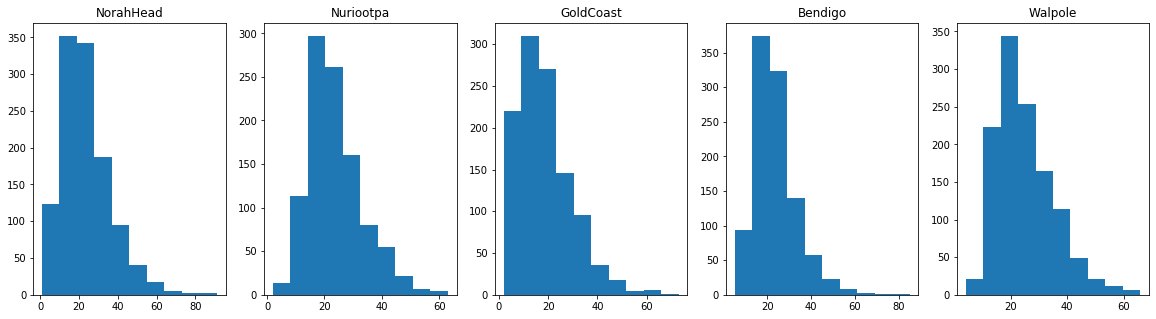

In [20]:
fig,ax=plt.subplots(1,5,figsize=(20,5))
print("Histogram plot of difference in WindGustSpeed and WindSpeed for different locations:\n");
for j,i in enumerate(data.Location.unique()):
    if j<5:
        ax[j].hist(data[(data.WindGustSpeed.notnull()) & (data.WindSpeed.notnull()) & (data.Location==i)].WindGustSpeed-
                   data[(data.WindGustSpeed.notnull()) & (data.WindSpeed.notnull()) & (data.Location==i)].WindSpeed)
        ax[j].set_title(i)

In [0]:
# for i in data.Location.unique():
#     plt.hist(data[(data.WindGustSpeed.notnull()) & (data.WindSpeed.notnull()) & (data.Location==i)].WindGustSpeed-data[(data.WindGustSpeed.notnull()) & (data.WindSpeed.notnull()) & (data.Location==i)].WindSpeed)
#     plt.show();
avg_difference_wind_speed={i:np.median(data[(data.WindGustSpeed.notnull()) & (data.WindSpeed.notnull()) & (data.Location==i)].WindGustSpeed-data[(data.WindGustSpeed.notnull()) & (data.WindSpeed.notnull()) & (data.Location==i)].WindSpeed) for i in data.Location.unique()}

for i in data[data["WindGustSpeed"].isnull()].index:
    data.loc[i,"WindGustSpeed"]=data.loc[i,"WindSpeed"]+avg_difference_wind_speed[data.loc[i,"Location"]]

for i in data[data["WindSpeed"].isnull()].index:
    data.loc[i,"WindSpeed"]=data.loc[i,"WindGustSpeed"]-avg_difference_temp[data.loc[i,"Location"]]

In [0]:
for i in test_data[test_data["WindGustSpeed"].isnull()].index:
    test_data.loc[i,"WindGustSpeed"]=test_data.loc[i,"WindSpeed"]+avg_difference_wind_speed[test_data.loc[i,"Location"]]

for i in test_data[test_data["WindSpeed"].isnull()].index:
    test_data.loc[i,"WindSpeed"]=test_data.loc[i,"WindGustSpeed"]-avg_difference_temp[test_data.loc[i,"Location"]]

**For imputing values of Humidity, we use linear regression as it has good correlation with other columns. The features that we will be using give us a very good R-square score of around .7 which means that they can explain the variance in Humidity with good accuracy. So, we impute the value of Humidity using the linear regression model.**

In [0]:
#Making a dictionary which will have the Location and Wind Direction which will have key and value pair for conversion
#from categorical to numerical variables
location_encodings={i:j for j,i in enumerate(data.Location.unique())}
direction_encodings={i:j for j,i in enumerate(data.WindDir.unique())}

In [0]:
# We make our train data using the rows which have the Humidity values and also making sure that all the other columns don't
# have missing values 
train_lr=data[(data.MaxTemp.notnull()) & (data.MinTemp.notnull())  & (data.Rainfall.notnull()) & (data.WindGustSpeed.notnull()) & (data.Humidity.notnull())]

# We make our test data using the rows where we need to impute the Humidity values and also making sure that all the other 
# columns don't have missing values as they will be helpful in prediction. 
test_lr=data[(data.MaxTemp.notnull()) & (data.MinTemp.notnull()) & (data.Rainfall.notnull()) & (data.WindGustSpeed.notnull())   & (data.Humidity.isnull())]

In [0]:
#Converts the Location and Wind Direction from categorical to numerical variables
train_lr.replace(location_encodings,inplace=True)
test_lr.replace(location_encodings,inplace=True)

In [0]:
#One-hot encodes the categorical variable
for elem in location_encodings.values():
    train_lr[str(elem)] = (train_lr['Location'] == elem).astype(int)

for elem in location_encodings.values():
    test_lr[str(elem)] = (test_lr['Location'] == elem).astype(int)

In [0]:
# Below we have used a linear regression model which takes into account the interaction between the columns.
#Using the interaction variables significantly improved the Rsquare score of the model.
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X=poly.fit_transform(train_lr[['0', '1', '2', '3', '4', '5', '6',
       '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '20', '21', '23', '24', '25', '26', '27', '28', '29', '30', '31',
       '32', '34', '35', '36', '33', '38', '39', '22', '40', '41', '42', '43',
       '44', '45', '37', '46', '47', '48','WindGustSpeed','MaxTemp','Rainfall',"MinTemp"]])

In [0]:
#Perform transformation on the data where we need to impute the missing Humidity value
transformed_test_lr=poly.transform(test_lr[['0', '1', '2', '3', '4', '5', '6',
       '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '20', '21', '23', '24', '25', '26', '27', '28', '29', '30', '31',
       '32', '34', '35', '36', '33', '38', '39', '22', '40', '41', '42', '43',
       '44', '45', '37', '46', '47', '48','WindGustSpeed','MaxTemp','Rainfall',"MinTemp"]])

In [0]:
lr=LinearRegression()

In [30]:
lr.fit(X,train_lr["Humidity"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
print("The Rsquare score for our model:",lr.score(X,train_lr["Humidity"]))

The Rsquare score for our model: 0.6849152909930998


In [0]:
#Here we fill the missing values of Humidity using the linear regression model
data.loc[test_lr.index,"Humidity"]=lr.predict(transformed_test_lr)

In [0]:
# Below, we perform the same steps on our test data 
test_data_lr=test_data[(test_data.MaxTemp.notnull()) & (test_data.MinTemp.notnull()) & (test_data.Rainfall.notnull()) & (test_data.WindGustSpeed.notnull()) & (test_data.Humidity.isnull())]

test_data_lr.replace(location_encodings,inplace=True)

for elem in location_encodings.values():
    test_data_lr[str(elem)] = (test_data_lr['Location'] == elem).astype(int)

transformed_test_data_lr=poly.transform(test_data_lr[['0', '1', '2', '3', '4', '5', '6',
       '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '20', '21', '23', '24', '25', '26', '27', '28', '29', '30', '31',
       '32', '34', '35', '36', '33', '38', '39', '22', '40', '41', '42', '43',
       '44', '45', '37', '46', '47', '48','WindGustSpeed','MaxTemp','Rainfall',"MinTemp"]])

test_data.loc[test_data_lr.index,"Humidity"]=lr.predict(transformed_test_data_lr)

**The Pressure for different locations is having normal distribution with a slight left skew. So, we us the median values to impute the missing data for the Pressure column.**

Histogram plot of Pressure at different locations:



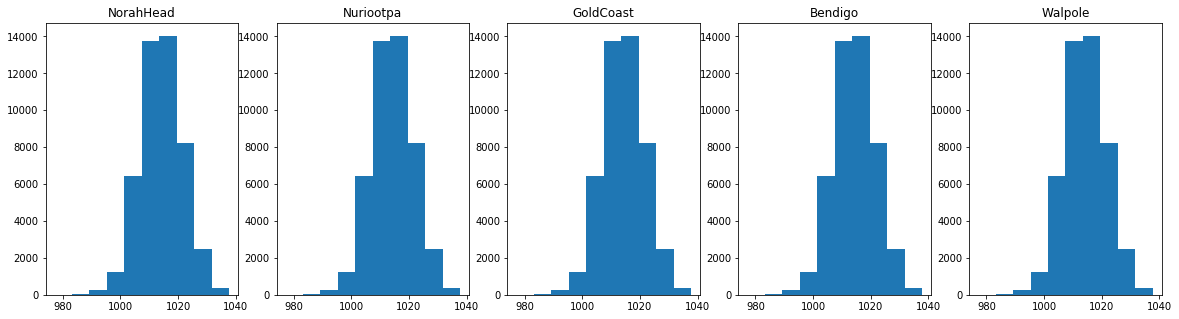

In [34]:
fig,ax=plt.subplots(1,5,figsize=(20,5))
print("Histogram plot of Pressure at different locations:\n");
for j,i in enumerate(data.Location.unique()):
    if j<5:
        ax[j].hist(data[data.Pressure.notnull()].Pressure)
        ax[j].set_title(i)

In [0]:
for i in data[data.Pressure.isnull()].Location.unique():
    indexes=data[(data.Pressure.isnull()) & (data.Location==i)].index
    data.loc[indexes,"Pressure"]=np.nanmedian(data[data.Location==i].Pressure)

In [0]:
for i in data[data.Pressure.isnull()].Location.unique():
    indexes=data[(data.Pressure.isnull()) & (data.Location==i)].index
    data.loc[indexes,"Pressure"]=np.nanmedian(data[data.Location==i].Pressure)

In [0]:
for i in test_data[test_data.Pressure.isnull()].Location.unique():
    indexes=test_data[(test_data.Pressure.isnull()) & (test_data.Location==i)].index
    test_data.loc[indexes,"Pressure"]=np.nanmedian(data[data.Location==i].Pressure)

**Some of the locations have all the values missing for a specific columns so it is impossible to impute based on their location. So, we use the median values for numerical columns and mode values for categorical columns to fill the missing data. The median is calculated using the entire column.**

In [0]:
location_all_rows_missing=[]
for i in data.Location.unique():
    if any(data[data.Location==i].isnull().sum()==len(data[data.Location==i])):
        location_all_rows_missing.append(i)

In [39]:
# List of locations which have all the values missing for a specific column
for i in location_all_rows_missing:
    print(i)

MountGinini
Newcastle
Albany
Penrith
SalmonGums


In [0]:
for i in data.columns:
    if any(data[i].isnull()):
            indexes=data[data[i].isnull()].index
            if data[i].dtype==np.float:
                data.loc[indexes,i]=np.nanmedian(data[i])
            else:
                data.loc[indexes,i]=data[i].mode()[0]

**Now, that we have the filled all the data in our training set, we can fill the missing data in our test set using medians and modes of the location.**

In [0]:
for i in test_data.columns:
    if any(test_data[i].isnull()):
        for j in test_data.Location.unique():
            indexes=test_data[(test_data["Location"]==j) & (test_data[i].isnull())].index
            if test_data[i].dtype==np.float:
                test_data.loc[indexes,i]=np.median(data[data.Location==j][i])
            else:
                test_data.loc[indexes,i]=data[data.Location==j][i].mode()[0]

**Finally, we check that our test and train data don't contain missing values.**

In [42]:
data.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir          0
WindSpeed        0
Humidity         0
Pressure         0
RainToday        0
RainTomorrow     0
dtype: int64

In [43]:
test_data.isnull().sum()

ID               0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir          0
WindSpeed        0
Humidity         0
Pressure         0
RainToday        0
dtype: int64

# Model Building

### Decision Tree

**Steps to perform Decision Tree modeling:**
*   **For decision tree models, first we will convert all the categorical features into numerical feartures by label encoding.** 
*   **We will split our data into train and validation data to evaluate the performance of our model.**
*   **Then, using Grid Search of 10 folds we tune our hyperparameters to get a set of hyperparameters which gives us the best recall.**
*   **We are using recall to tune our model because we want our recall to be as high as possible. As recall is a measure of how well the classifier predicts that it will rain on the days when it rains i.e True Positive/(Number of Positives)**
*   **Using the hyperparameters that we get from our gridsearch we will use it to give the prediction for the test set.**

In [0]:
#We copy the data so that we can perform transformations according to the requirement of the model
data_dt=data.copy()

In [0]:
test_data_dt=test_data.copy()

In [0]:
#Replace all the categorical columns with numerical values
data_dt.Location.replace(location_encodings,inplace=True)
data_dt.WindDir.replace(direction_encodings,inplace=True)
data_dt.WindGustDir.replace(direction_encodings,inplace=True)

In [0]:
#Replace all the categorical columns with numerical values
test_data_dt.Location.replace(location_encodings,inplace=True)
test_data_dt.WindDir.replace(direction_encodings,inplace=True)
test_data_dt.WindGustDir.replace(direction_encodings,inplace=True)

In [0]:
decision_tree=DecisionTreeClassifier(random_state=0)

In [0]:
#Splitting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(data_dt[data_dt.columns[:-1]], data_dt[data_dt.columns[-1]],test_size=0.1, random_state=0)

**The parameters that we will be using to tune our decision tree model are:
<br> 
<br>    Criterion: The criterion that we will be using to split a node will be either using gini index or entropy.
<br>    Min_Samples_Split: This ensures that a node is split only when a minimum number of samples are present in the node.
<br>    Max_Depth: It is the maximum depth till which the tree will keep splitting. It ensures that the tree does not overfit the data.
<br>    Min_Samples_Leaf: This helps in pruning the decision tree, as it will ensure that the leafs contain atleast the mentioned number of samples.
<br> Max_leaf_Nodes: Total number of terminal nodes in a tree.**

In [0]:
param_grid = { 'criterion':['gini','entropy'],
              'min_samples_split':[25,50,100,200],
              'max_depth': [1,4,5, 10, 20, 25, 30],
              'min_samples_leaf': [1,3, 5, 10,20],
              'max_leaf_nodes': [2, 5, 10, 20,40]}

In [0]:
# We perform grid search using 10 folds and setting recall as the metrics that we need to maximize.
dtree_gscv = GridSearchCV(decision_tree, param_grid, cv=10,scoring='recall')

In [50]:
dtree_gscv.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 4, 5, 10, 20, 25, 30],
  

In [52]:
dtree_gscv.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_leaf_nodes': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 25}

**From our classification report for the training and the validation set we can infer that our model does not overfit on the training data. It is able to perform equally well on our testing data as it is performing on our training data. The recall value of 0.75 tells us that our model is able to predict 75% of the time when it rains. The results that we have got from our model are good when we take into consideration the amount of values that were missing from our data.**

In [53]:
print(classification_report(dtree_gscv.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76     23419
           1       0.76      0.75      0.76     23343

    accuracy                           0.76     46762
   macro avg       0.76      0.76      0.76     46762
weighted avg       0.76      0.76      0.76     46762



In [54]:
print(classification_report(dtree_gscv.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      2653
           1       0.76      0.75      0.75      2543

    accuracy                           0.76      5196
   macro avg       0.76      0.76      0.76      5196
weighted avg       0.76      0.76      0.76      5196



**The ROC_AUC score that we get from the graph that we have plotted below tells us that our model is able to distinguish between the days, if it will rain tomorrow or not, 83.7% of the time. The score is above 50% which means that the model is not just randomly predicting the probability of raining tomorrow.**

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.837


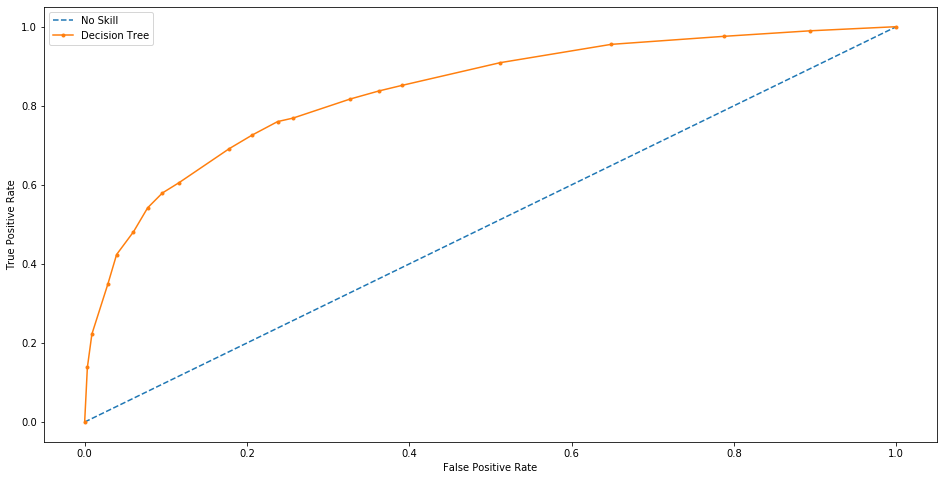

In [73]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = dtree_gscv.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.figure(figsize=(16,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Decision Tree')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [0]:
dtree_predictions=dtree_gscv.predict(test_data_dt[test_data_dt.columns[test_data_dt.columns!="ID"]])

### K-means Clustering

**Repurposing unsupervised cluster based algrithms for classification problem:**
<br>**We have repurposed the unsupervised algorithm by using it to form two clusters which we will be using to classify our data. In practice, while using unsupervised algorithm the true labels are not present. But, in our case, as the data labels are present we can use it perform tuning of our model. As, it will help us to get the hyperparameters which performs the clusters which best classifies the data.**
<br>
<br>
 **Steps to perform K-means:**

*   **For KMeans Clustering, we will first remove all the categorical variables as one hot encoding them will not help. This is due to the fact that binary coding will produce high density regions which will affect our model performance.**
*   **Then, we will split our data set into training and validation set to check if the model does not overfit training data.**

*   **After that we will scale our columns between 0 and 1 using minmax scaler, so that all the variable are on the same scale. This is the most important thing that can impact the performance of kmeans clustering.**
*   **We will fine tune different hyperparameters using grid search inorder to produce the set of hyperparameters that will give us good predictions and improve the metrics score making sure the model does not overfit on training data.** 
*   **For evaluating the performance of our model we will use recall as we need to maximize the times the model correctly predicts the rains when it actually rains.**

In [0]:
data_km=data.copy()

In [0]:
test_data_km=test_data.copy()

In [0]:
#Dropping the categorical columns
data_km.drop(["Location",'WindDir','WindGustDir','RainToday'],axis=1,inplace=True)
test_data_km.drop(["Location",'WindDir','WindGustDir','RainToday'],axis=1,inplace=True)

In [0]:
#Spliting our train data into train and cross validation set
X_train, X_test, y_train, y_test = train_test_split(data_km[data_km.columns[data_km.columns!="RainTomorrow"]], data_km[data_km.columns[data_km.columns=="RainTomorrow"]],test_size=0.1, random_state=0)

In [0]:
scalar=MinMaxScaler()

In [0]:
#Scaling our train data
X_train=scalar.fit_transform(X_train)

In [0]:
#Scaling our cross validation data
X_test=scalar.transform(X_test)

In [0]:
#Scaling our test data
test_data_km=scalar.transform(test_data_km[test_data_km.columns[test_data_km.columns!="ID"]])

In [0]:
kmeans=KMeans(n_clusters=2,random_state=0)

**Parameters to tune:**


**1.**   **Max Iterations: The maximum number of iterations after which the model stops to optimize the centroids of the cluster.**
<br>**2.**   **n_init: The number of times the model starts to run from a random centroid point.**



In [0]:
param_grid_kmeans={'max_iter':[10,20,50,100],'n_init':[10,20,25,50]}

In [0]:
kmeans_gscv = GridSearchCV(kmeans, param_grid_kmeans, cv=10,scoring='recall')

In [99]:
kmeans_gscv.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=2, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=0, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'max_iter': [10, 20, 50, 100],
                         'n_init': [10, 20, 25, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [133]:
kmeans_gscv.best_params_

{'max_iter': 10, 'n_init': 20}

In [100]:
print(classification_report(kmeans_gscv.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.52      0.61      0.56     20367
           1       0.65      0.57      0.61     26395

    accuracy                           0.59     46762
   macro avg       0.59      0.59      0.58     46762
weighted avg       0.60      0.59      0.59     46762



In [101]:
print(classification_report(kmeans_gscv.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.51      0.62      0.56      2234
           1       0.66      0.56      0.60      2962

    accuracy                           0.58      5196
   macro avg       0.59      0.59      0.58      5196
weighted avg       0.60      0.58      0.59      5196



In [0]:
kmeans_predictions=kmeans_gscv.predict(test_data_km)

### Hierarichal Agglomerative Clustering

**Steps to perform HAC:**
*   **For HAC, there is no predict function so we will train the data on the whole training data set to evaluate the performance of our HAC model.**
*   **For HAC, we will first remove all the categorical variables as one hot encoding them will not help. This is due to the fact that binary coding will produce high density regions which will affect our model performance.**
*   **Then, we will scale the data using MinMax scaler so that all the data is on the same scale. This is an important step as it can significantly affect our model performance.** 
*   **Using the metrics score that we get after training the whole dataset, we will use the same parameters for training the test data to generate predictions.**
*   **It is not possible to run on the combined train and test data due to limitation of resources.**

In [0]:
data_hac=data.copy()
test_data_hac=test_data.copy()

In [0]:
#Dropping the categorical columns as it will cause high density regions as discussed above in Kmeans
data_hac.drop(["Location",'WindDir','WindGustDir','RainToday'],axis=1,inplace=True)
test_data_hac.drop(["Location",'WindDir','WindGustDir','RainToday','ID'],axis=1,inplace=True)

In [0]:
#Pops the true labels for training data
training_labels_hac=data_hac.pop("RainTomorrow")

In [0]:
scalar_hac=MinMaxScaler()

In [0]:
#Scales the training data
data_hac=scalar_hac.fit_transform(data_hac)

In [0]:
#Scales the test data
test_data_hac=scalar_hac.transform(test_data_hac)

In [0]:
ag=AgglomerativeClustering(n_clusters=2,linkage="ward").fit(data_hac)

In [144]:
print(classification_report(ag.labels_,training_labels_hac))

              precision    recall  f1-score   support

           0       0.62      0.56      0.58     29216
           1       0.49      0.55      0.52     22742

    accuracy                           0.56     51958
   macro avg       0.55      0.55      0.55     51958
weighted avg       0.56      0.56      0.56     51958



In [0]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [0]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

In [117]:
model.fit(data_hac)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=0, linkage='ward',
                        memory=None, n_clusters=None)

Below is the dendogram plot of how the data points are clustered


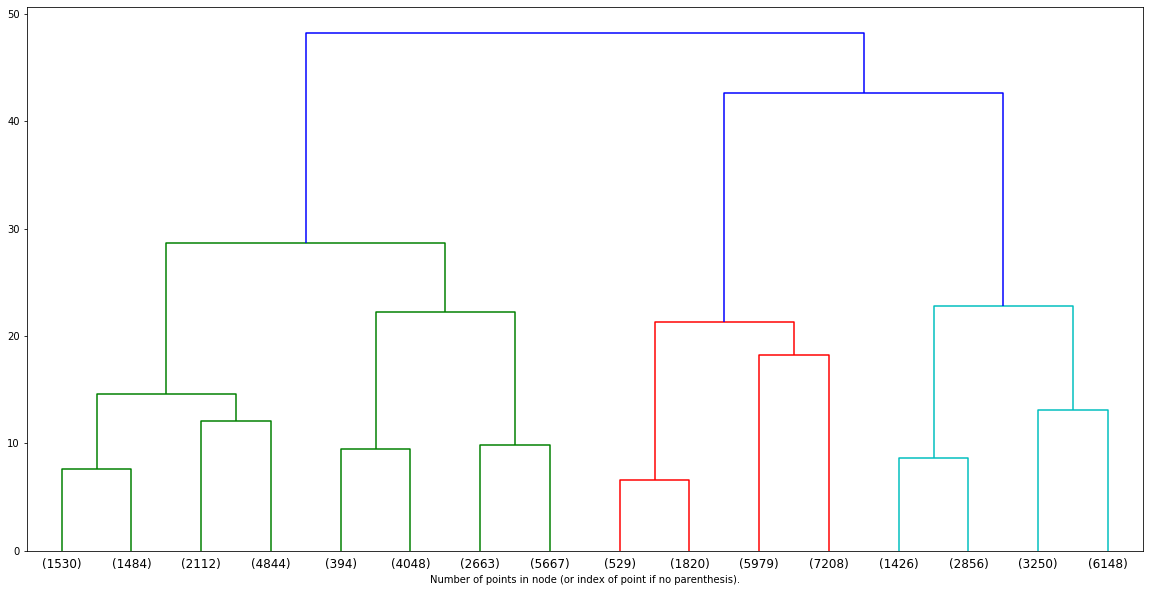

In [119]:
print("Below is the dendogram plot of how the data points are clustered")
plt.figure(figsize=(20,10))
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [0]:
#Fitting the hac model on test dataset
ag_test=AgglomerativeClustering(n_clusters=2).fit(test_data_hac)

In [0]:
hac_predictions=ag_test.labels_

In [0]:
summary=pd.DataFrame({"Algorithm":["Decision Tree","K-means","HAC"], "Recall":[0.75,0.56,0.55],"Hyperparameters":["criterion:entropy,max_depth:10,max_leaf_nodes:20,min_samples_leaf:1,min_samples_split:25","max_iter:10,n_init:20",'linkage:ward']})

In [150]:
summary

,Algorithm,Recall,Hyperparameters
0,Decision Tree,0.75,"criterion:entropy,max_depth:10,max_leaf_nodes:..."
1,K-means,0.56,"max_iter:10,n_init:20"
2,HAC,0.55,linkage:ward


**Interpretation of Results:**
**The decision tree is by far our best model that we can use for predicting if it will rain or not tomorrow. The K-means and HAC did not perform well, which can be imputed to the fact that the data can be classified more accurrately by drawing linear decision boundaries than using two clusters to classify the whole data.** 

## Test Set Prediction

**We make a final dataframe containing the test set predictions for all the three algorithms.**

In [0]:
final_predictions=pd.DataFrame({"ID":test_data.ID,"kmeans":kmeans_predictions,"HAC":hac_predictions,"DT":dtree_predictions})

In [0]:
final_predictions.to_csv("Final_predictions.csv",index=False)